In [16]:
!cp /kaggle/input/outputmodel/* /kaggle/working/Model/

In [17]:
!pip install timm

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

device = 'cuda:0'

model1 = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
model2 = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
model3 = timm.create_model('vgg16', num_classes=2, pretrained=True).to(device)
x     = torch.randn(32, 3, 224, 224).to(device)
model1(x).shape

torch.Size([32, 2])

In [19]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

## Create DataLoader

In [20]:
import os
from PIL import Image
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from tqdm.autonotebook import tqdm

In [21]:
LABEL = {0: 'fake', 1: 'real'}

In [22]:
class ImageDataset(Dataset):
    def __init__(self, root: str, transform=None):
        self.root = root
        self.transform = transform
        self.files = self.load()

    def load(self):
        files = list()
        for file in os.listdir(self.root):
            if file.startswith('fake_'):
                label = 0
            elif file.startswith('real_'):
                label = 1
            else:
                continue
            files.append((os.path.join(self.root, file), label))
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file, label = self.files[idx]
        image = Image.open(file).convert('RGB')
        if self.transform:
           image = self.transform(image)
        return image, label

In [23]:
def CreateDataLoader(root: str) -> Tuple[DataLoader, DataLoader, DataLoader]:
    # Path of Image Data
    train = os.path.join(root, 'train')
    valid = os.path.join(root, 'val')
    test = os.path.join(root, 'test')

    # Transform Image Data
    transform = tf.Compose([
        tf.Resize((224, 224)),
        tf.ToTensor(),
        tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create ImageFolder Dataset
    train_ds = ImageDataset(root=train, transform=transform)
    valid_ds = ImageDataset(root=valid, transform=transform)
    test_ds = ImageDataset(root=test, transform=transform)

    # Create DataLoader
    batch_size = 32  # Min-batches
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    return train_dl, valid_dl, test_dl

In [24]:
# Directories
highf2f_dir = '/kaggle/input/deepfake/High Quality-20230515T182106Z-001/High Quality/f2f_data'
highnt_dir = '/kaggle/input/deepfake/High Quality-20230515T182106Z-001/High Quality/nt_data'
lowf2f_dir = '/kaggle/input/deepfake/Low Quality-20230515T182346Z-001/Low Quality/f2f_data'
lownt_dir = '/kaggle/input/deepfake/Low Quality-20230515T182346Z-001/Low Quality/nt_data'

highf2f_dl = list(CreateDataLoader(highf2f_dir))
highnt_dl = list(CreateDataLoader(highnt_dir))
lowf2f_dl = list(CreateDataLoader(lowf2f_dir))
lownt_dl = list(CreateDataLoader(lownt_dir))

## Train Model

In [31]:
def train(train_dl, valid_dl, model, optimizer, num_epochs=100, save=False, save_path=None):
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    best_valid_loss = float('inf')  # 초기 최소 검증 손실값 설정
    best_model = None
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and weight update
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Record training loss and accuracy for each epoch
        train_loss = total_loss / len(train_dl)
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_dl:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Record training loss and accuracy for each epoch
        valid_loss = total_loss / len(valid_dl)
        valid_acc = 100.0 * correct / total
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        # Print Result for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.2f}%')
        
        # Check if current model has the best validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model.state_dict()

    if save and best_model is not None:
        checkpoint = {
            'model_state_dict': best_model,
            'metrics': {
                'train_loss': train_losses,
                'train_acc': train_accs,
                'valid_loss': valid_losses,
                'valid_acc': valid_accs
            }
        }
        torch.save(checkpoint, save_path)
    return train_losses, train_accs, valid_losses, valid_accs

In [26]:
def loadTrainedModel(model):
    metrics = model['metrics']
    train_losses = metrics['train_loss']
    train_accs = metrics['train_acc']
    valid_losses = metrics['valid_loss']
    valid_accs = metrics['valid_acc']
    return train_losses, train_accs, valid_losses, valid_accs

In [27]:
import matplotlib.pyplot as plt

def plot(train_losses, train_accs, valid_losses, valid_accs, model_name, dataloader_category):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name}: {dataloader_category} Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(valid_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name}: {dataloader_category} Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [28]:
model_optimizers = {
    'Efficient_b0': [model1, optimizer1],
    'Xception': [model2, optimizer2],
    'VGG16': [model3, optimizer3],
}

dataloaders = {
    'HighF2F': highf2f_dl,
    'HighNT': highnt_dl,
    'LowF2F': lowf2f_dl,
    'LowNT': lownt_dl,
}

In [13]:
!mkdir '/kaggle/working/Model'

mkdir: cannot create directory ‘/kaggle/working/Model’: File exists


In [ ]:
model_dir = '/kaggle/working//Model'
results = list()

for name, model_optimizer in model_optimizers.items():
    for category, dataloader in dataloaders.items():
        model, optimizer = model_optimizer
        train_dl, valid_dl = dataloader[:2]
        save_path = os.path.join(model_dir, f'{name}_{category}.pth')
#         if os.path.exists(save_path):
#             print(f'-----Already Trained {name} model for {category} Dataset-----')
#             model = torch.load(save_path)
#             results.append([name, category, loadTrainedModel(model)])
#             continue
        print(f'\n-----Train {name} model for {category} Dataset-----')
        result = train(train_dl, valid_dl, model, optimizer, num_epochs=30, save=True, save_path=save_path)
        results.append([name, category, result])


-----Train Efficient_b0 model for HighF2F Dataset-----
Epoch [1/30], Train Loss: 1.9957, Train Acc: 75.25%, Val Loss: 0.8849, Val Acc: 81.59%
Epoch [2/30], Train Loss: 0.5813, Train Acc: 90.42%, Val Loss: 0.3001, Val Acc: 93.78%
Epoch [3/30], Train Loss: 0.1553, Train Acc: 96.08%, Val Loss: 0.2253, Val Acc: 95.77%
Epoch [4/30], Train Loss: 0.0197, Train Acc: 99.33%, Val Loss: 0.1637, Val Acc: 95.52%
Epoch [5/30], Train Loss: 0.0112, Train Acc: 99.58%, Val Loss: 0.1861, Val Acc: 95.27%
Epoch [6/30], Train Loss: 0.0070, Train Acc: 99.75%, Val Loss: 0.2069, Val Acc: 94.28%


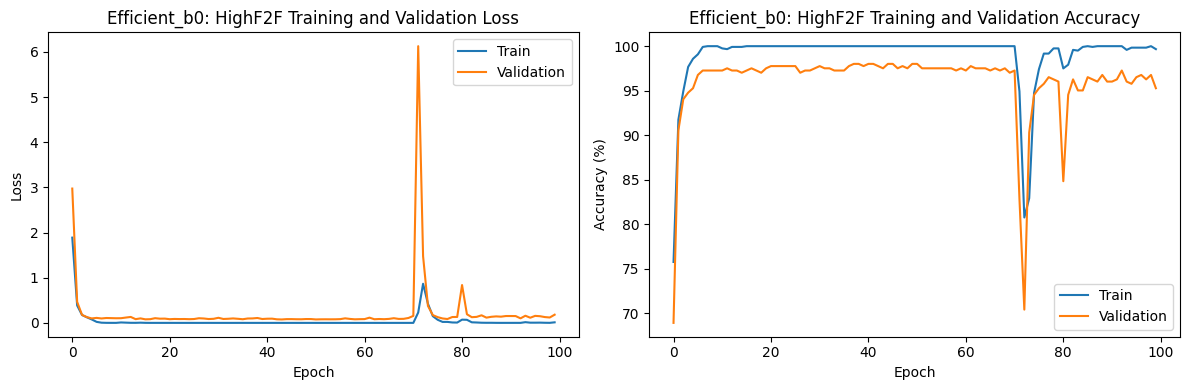

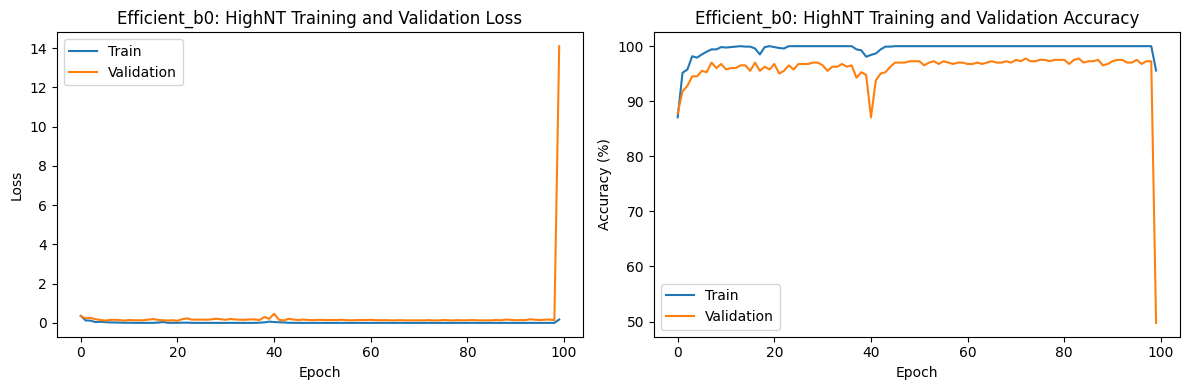

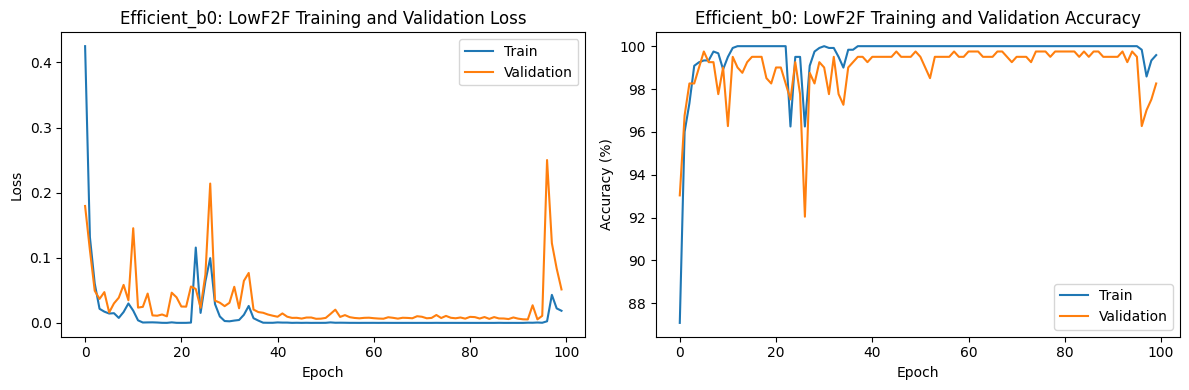

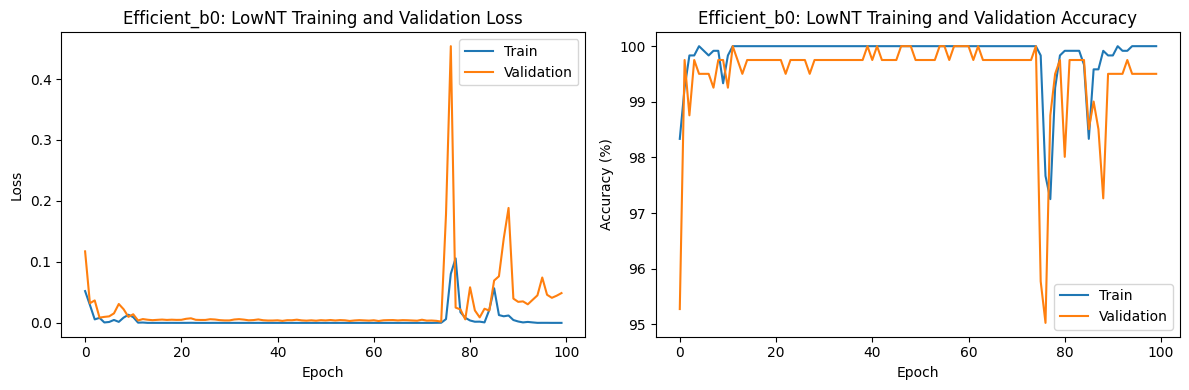

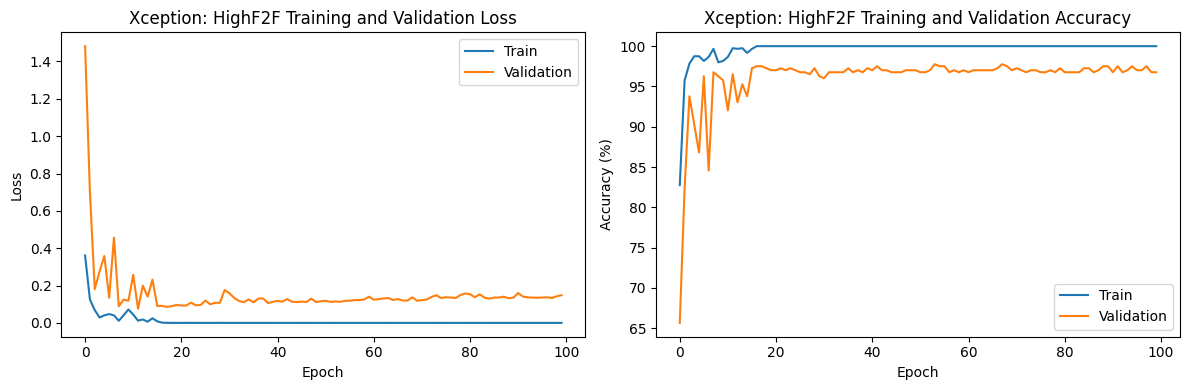

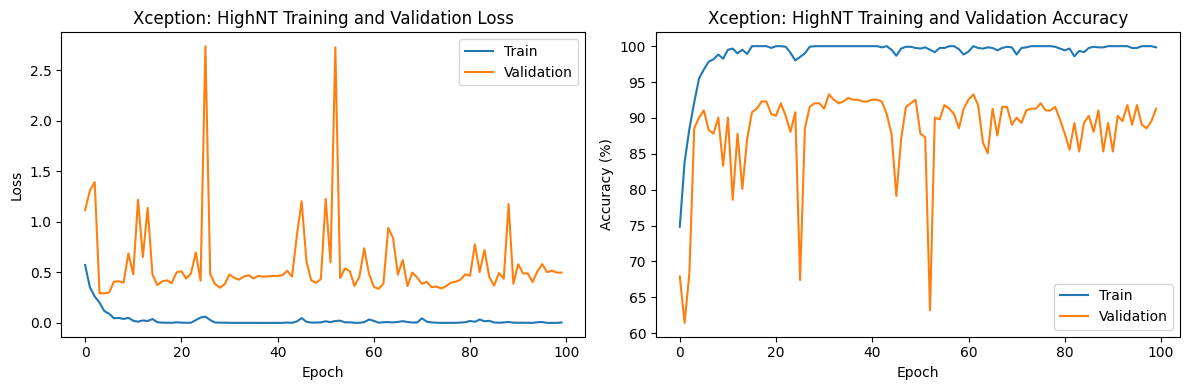

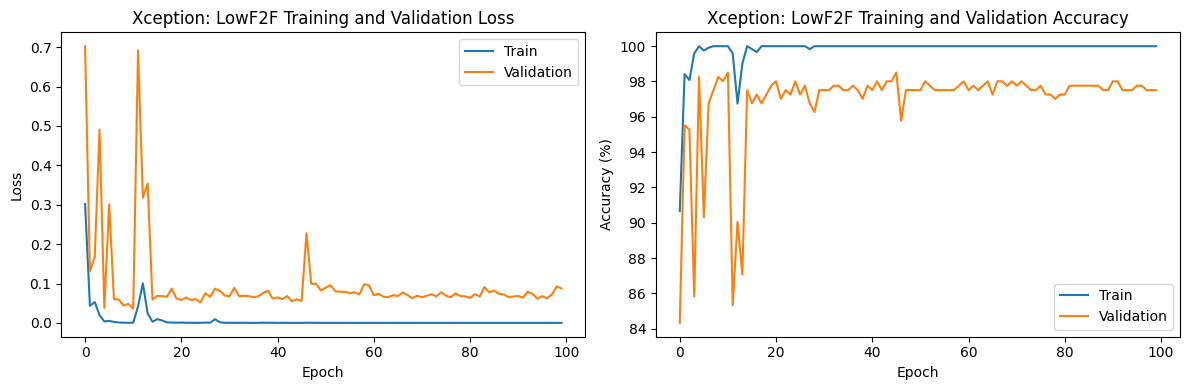

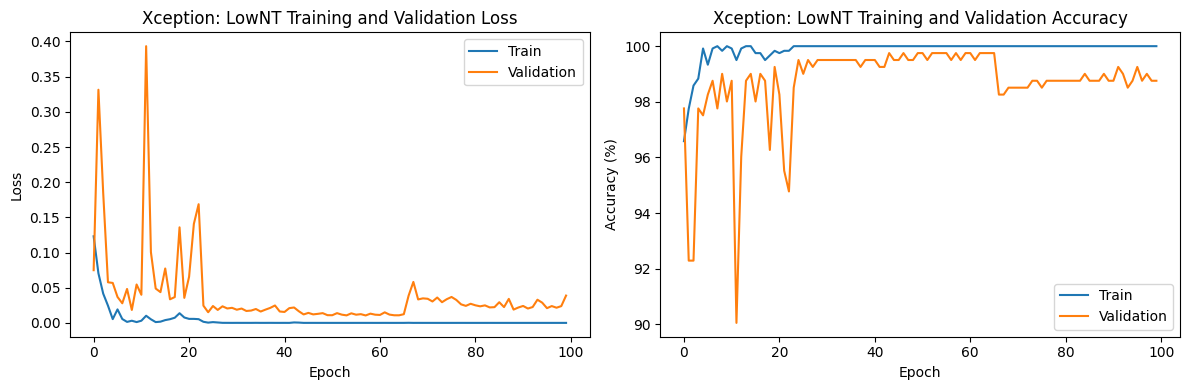

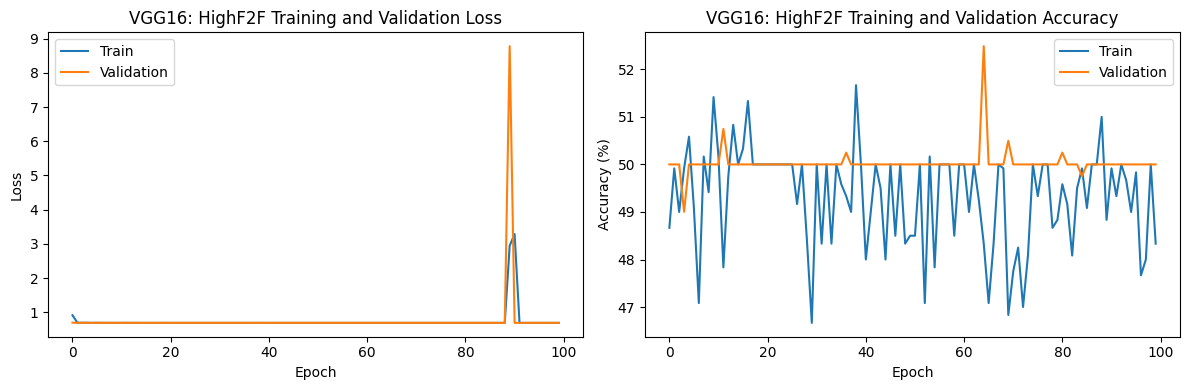

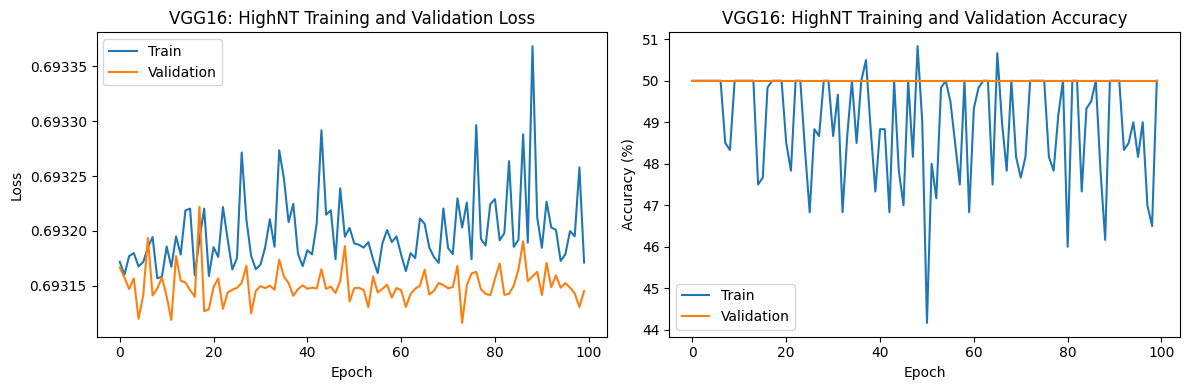

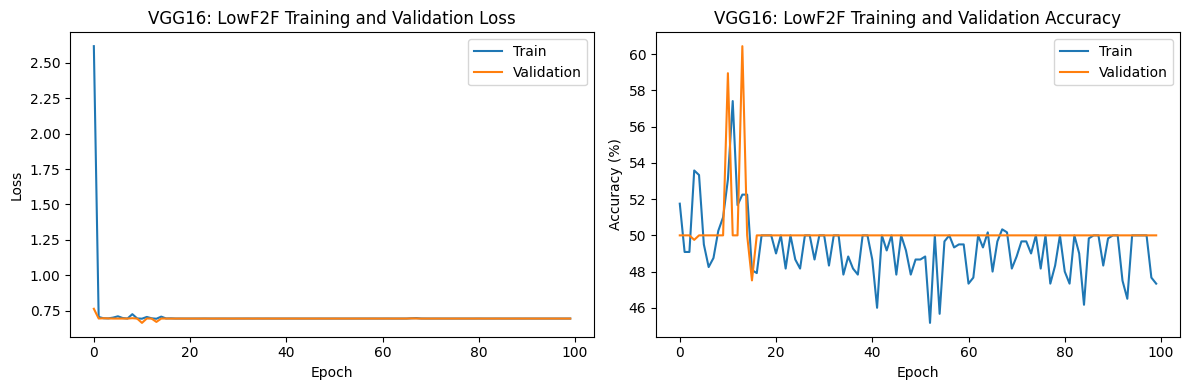

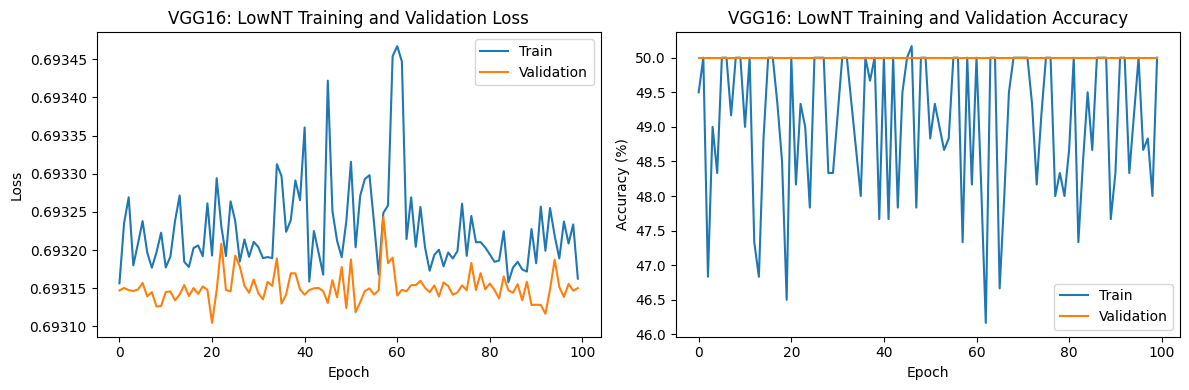

In [30]:
for result in results:
    model_name = result[0]
    dataloader_category = result[1]
    train_losses, train_accs, valid_losses, valid_accs = result[2]
    plot(train_losses, train_accs, valid_losses, valid_accs, model_name, dataloader_category)

## Test Model

In [ ]:
def test(test_dl, model):
    